In [17]:
import os
import sys

# Adicionar diretório pai ao path para imports
sys.path.insert(0, os.path.abspath('..'))

import configparser
import matplotlib.pyplot as plt
from utils.chart_utils import (
    load_forecasts_for_regions,
    load_product_forecasts,
    load_product_historical_data,
    setup_plot_style,
    format_yticks_with_comma,
    add_forecast_annotation,
    plot_product_chart,
    save_figure
)

# ============================================================================
# CONFIGURAÇÕES GLOBAIS
# ============================================================================

MODEL = 'RNN'
FORECAST_HORIZON = 3
REGIONS = ['ilheus', 'itabuna']
PRODUTOS = ['acucar', 'arroz', 'banana', 'cafe', 'carne', 'farinha',
            'feijao', 'leite', 'manteiga', 'oleo', 'pao', 'tomate']

QUANTIDADES = {
    'acucar': 3.0, 'arroz': 3.6, 'banana': 7.5, 'cafe': 0.3,
    'carne': 4.5, 'farinha': 3.0, 'feijao': 4.5, 'leite': 6.0,
    'manteiga': 0.75, 'oleo': 1.0, 'pao': 6.0, 'tomate': 12.0
}

# Configurações visuais dos produtos
MARKERS_PRODUTOS = ['s', '.', 'v', 'p', 'p', 'X', '*', 'D', '^', '8', 'P', '>']

COLORS_PREV = [
    '#0004c7', '#c9261a', '#c1c718', '#57210a', '#6fad11', '#039eff',
    '#ffb100', '#00fa08', '#ff0044', '#210109', '#780c6d', '#b200b5'
]

COLORS_REAL = [
    '#7578ff', '#e6837c', '#c0c28c', '#634b41', '#aac77f', '#aadbfa',
    '#f7d381', '#a2fca4', '#f79cb4', '#736e6f', '#854e7f', '#c877c9'
]

MARKERS_SIZE_PRODUTOS = [8, 17, 10, 10, 10, 10, 15, 8, 10, 10, 10, 10]
LINE_SIZE = 3

# Gráfico previsão Cesta Básica

## Carregar configurações

In [18]:
# Carregamento das configurações
configs = configparser.ConfigParser()
configs.read('../../configuracoes_graficos.conf')

# Extrair valores da configuração
config_values = list(configs['CESTA_BASICA'].values())

# Parâmetros temporais
qtd_meses = int(config_values[0])
meses_previstos = [m.strip() for m in config_values[1].split(',')]
meses_anteriores = [m.strip() for m in config_values[2].split(',')]

# Valores reais históricos
valores_reais = {
    'ilheus': [float(v) for v in config_values[3].replace('[', '').replace(']', '').split(',')],
    'itabuna': [float(v) for v in config_values[4].replace('[', '').replace(']', '').split(',')]
}

# Configurações do eixo Y
eixo_y_limite_sup = int(config_values[5]) + 1
eixo_y_limite_inf = int(config_values[6])
eixo_y_varia_em = int(config_values[7])

# Outras configurações
ano_previsao = int(config_values[8])

# Validações
assert len(meses_previstos) == qtd_meses, "Quantidade de meses previstos inconsistente"
assert len(meses_anteriores) == 12 - qtd_meses, "Quantidade de meses anteriores inconsistente"
assert len(valores_reais['ilheus']) == len(meses_anteriores), "Quantidade de valores inconsistente"

print(f"✅ Configurações carregadas: {MODEL}, {qtd_meses} meses, {ano_previsao}")

✅ Configurações carregadas: RNN, 3 meses, 2026


## Carregar previsões

In [19]:
# Carregar previsões de ambas as regiões
previsoes = load_forecasts_for_regions(MODEL, 'cesta_basica', REGIONS, FORECAST_HORIZON)

print(f"✅ Previsões carregadas:")
for region, values in previsoes.items():
    print(f"  {region.capitalize()}: {[round(v, 2) for v in values]}")

✅ Previsões carregadas:
  Ilheus: [533.38, 544.9, 552.81]
  Itabuna: [591.85, 600.52, 607.25]


## Plotar gráfico

✅ Gráfico salvo em: ../../output/figure/previsao_cestaBasica_Jan-Mar_2026.png


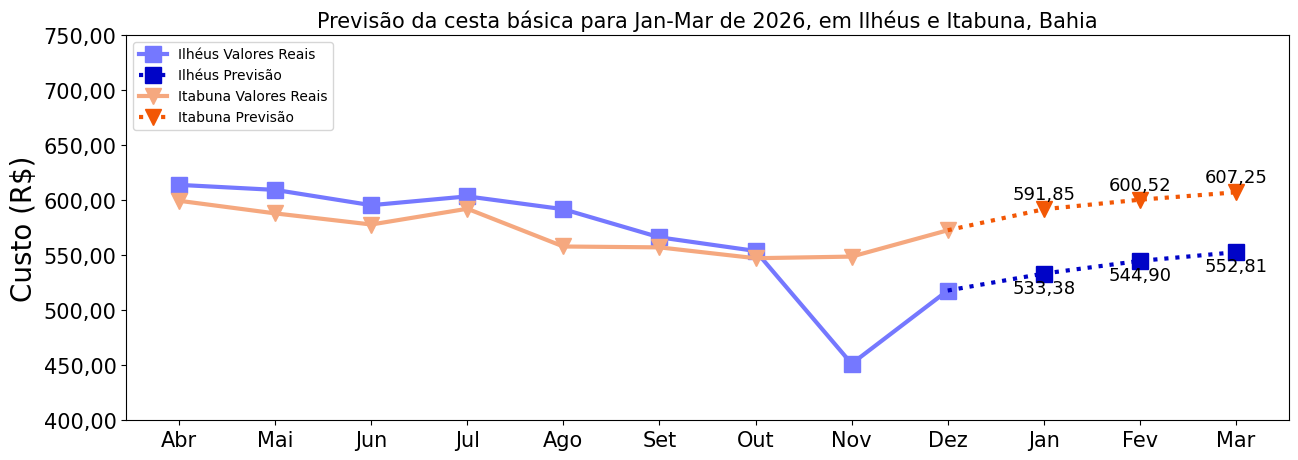

In [20]:
# Configurações visuais para cesta básica
MARKER_SIZE = 12
MARKERS_CESTA = ['s', 'v']  # Quadrado, triângulo
COLORS_CESTA_REAL = ['#7578ff', '#f5a87f']
COLORS_CESTA_FORECAST = ['#0004c7', '#f25705']
LABELS_CESTA_REAL = ['Ilhéus Valores Reais', 'Itabuna Valores Reais']
LABELS_CESTA_FORECAST = ['Ilhéus Previsão', 'Itabuna Previsão']

# Preparar dados
x_label = meses_anteriores + meses_previstos
combined_values = {
    region: valores_reais[region] + [round(v, 2) for v in previsoes[region]]
    for region in REGIONS
}

# Criar figura
fig, ax = setup_plot_style(figsize=(15, 5))

# Plotar para cada região
for i, region in enumerate(REGIONS):
    # Valores reais
    ax.plot(range(9), valores_reais[region],
            marker=MARKERS_CESTA[i], label=LABELS_CESTA_REAL[i],
            color=COLORS_CESTA_REAL[i], lw=LINE_SIZE, markersize=MARKER_SIZE)

    # Linha de conexão
    ax.plot([8, 9], [valores_reais[region][-1], previsoes[region][0]], ':',
            color=COLORS_CESTA_FORECAST[i], lw=LINE_SIZE, markersize=MARKER_SIZE)

    # Previsões
    ax.plot([9, 10, 11], previsoes[region], ":",
            marker=MARKERS_CESTA[i], label=LABELS_CESTA_FORECAST[i],
            color=COLORS_CESTA_FORECAST[i], lw=LINE_SIZE, markersize=MARKER_SIZE)

    # Anotações
    for j in range(9, 12):
        ilheus_val = combined_values['ilheus'][j]
        itabuna_val = combined_values['itabuna'][j]
        current_val = combined_values[region][j]

        # Determinar posição da anotação
        if region == 'ilheus':
            va = 'bottom' if ilheus_val >= itabuna_val else 'top'
        else:
            va = 'bottom' if itabuna_val >= ilheus_val else 'top'

        add_forecast_annotation(ax, j, current_val, current_val, offset=5, va=va)

# Formatação
ax.set_xticks(range(12))
ax.set_xticklabels(x_label, size=15)
ax.set_ylabel("Custo (R$)", size=20)

# Formatar eixo Y - ajuste automático do intervalo
y_range = eixo_y_limite_sup - eixo_y_limite_inf
# Ajustar intervalo baseado no range: mínimo 5 ticks, máximo 15 ticks
ideal_num_ticks = 10
intervalo_ideal = y_range / ideal_num_ticks
# Arredondar para múltiplos de 5, 10, 20, 50, etc.
if intervalo_ideal <= 5:
    y_step = 5
elif intervalo_ideal <= 10:
    y_step = 10
elif intervalo_ideal <= 20:
    y_step = 20
elif intervalo_ideal <= 50:
    y_step = 50
else:
    y_step = int(intervalo_ideal / 10) * 10

yticks_range = range(eixo_y_limite_inf, eixo_y_limite_sup, y_step)
format_yticks_with_comma(ax, yticks_range)

# Título e legenda
ax.set_title(f"Previsão da cesta básica para {meses_previstos[0]}-{meses_previstos[-1]} de {ano_previsao}, em Ilhéus e Itabuna, Bahia", size=15)
ax.legend(loc=2)

# Salvar
chart_name = f'../../output/figure/previsao_cestaBasica_{meses_previstos[0]}-{meses_previstos[-1]}_{ano_previsao}.png'
save_figure(chart_name)

plt.show()

# Gráficos previsão Produtos da Cesta Básica

## Carregar previsões dos produtos

In [21]:
# Carregar previsões dos produtos para ambas as regiões
produtos_previsoes = load_product_forecasts(MODEL, REGIONS, PRODUTOS, QUANTIDADES, FORECAST_HORIZON)

print(f"✅ Previsões de produtos carregadas:")
for region in REGIONS:
    print(f"\n{region.capitalize()}:")
    for produto in PRODUTOS[:3]:  # Mostrar apenas os 3 primeiros
        print(f"  {produto}: {[round(v, 2) for v in produtos_previsoes[region][produto]]}")
    print(f"  ... e {len(PRODUTOS) - 3} produtos adicionais")

✅ Previsões de produtos carregadas:

Ilheus:
  acucar: [4.31, 4.58, 4.39]
  arroz: [4.99, 4.71, 4.63]
  banana: [6.06, 6.31, 6.07]
  ... e 9 produtos adicionais

Itabuna:
  acucar: [4.41, 4.38, 4.56]
  arroz: [4.5, 4.55, 4.6]
  banana: [6.61, 6.72, 6.54]
  ... e 9 produtos adicionais


## Carregar valores reais dos produtos

In [22]:
# Carregar valores reais dos produtos usando função utilitária
data_folder = configs['PRODUTOS']['pasta']
sub_pasta_ios = configs['PRODUTOS']['subpasta_valores_reais_ios']
sub_pasta_itb = configs['PRODUTOS']['subpasta_valores_reais_itb']

valores_reais_ios = load_product_historical_data(
    data_folder, sub_pasta_ios, 'ilheus', PRODUTOS, QUANTIDADES, n_months=9
)

valores_reais_itb = load_product_historical_data(
    data_folder, sub_pasta_itb, 'itabuna', PRODUTOS, QUANTIDADES, n_months=9
)

print(f"✅ Valores reais carregados para ambas as regiões (últimos 9 meses)")

✅ Valores reais carregados para ambas as regiões (últimos 9 meses)


## Previsão dos produtos de Ilhéus

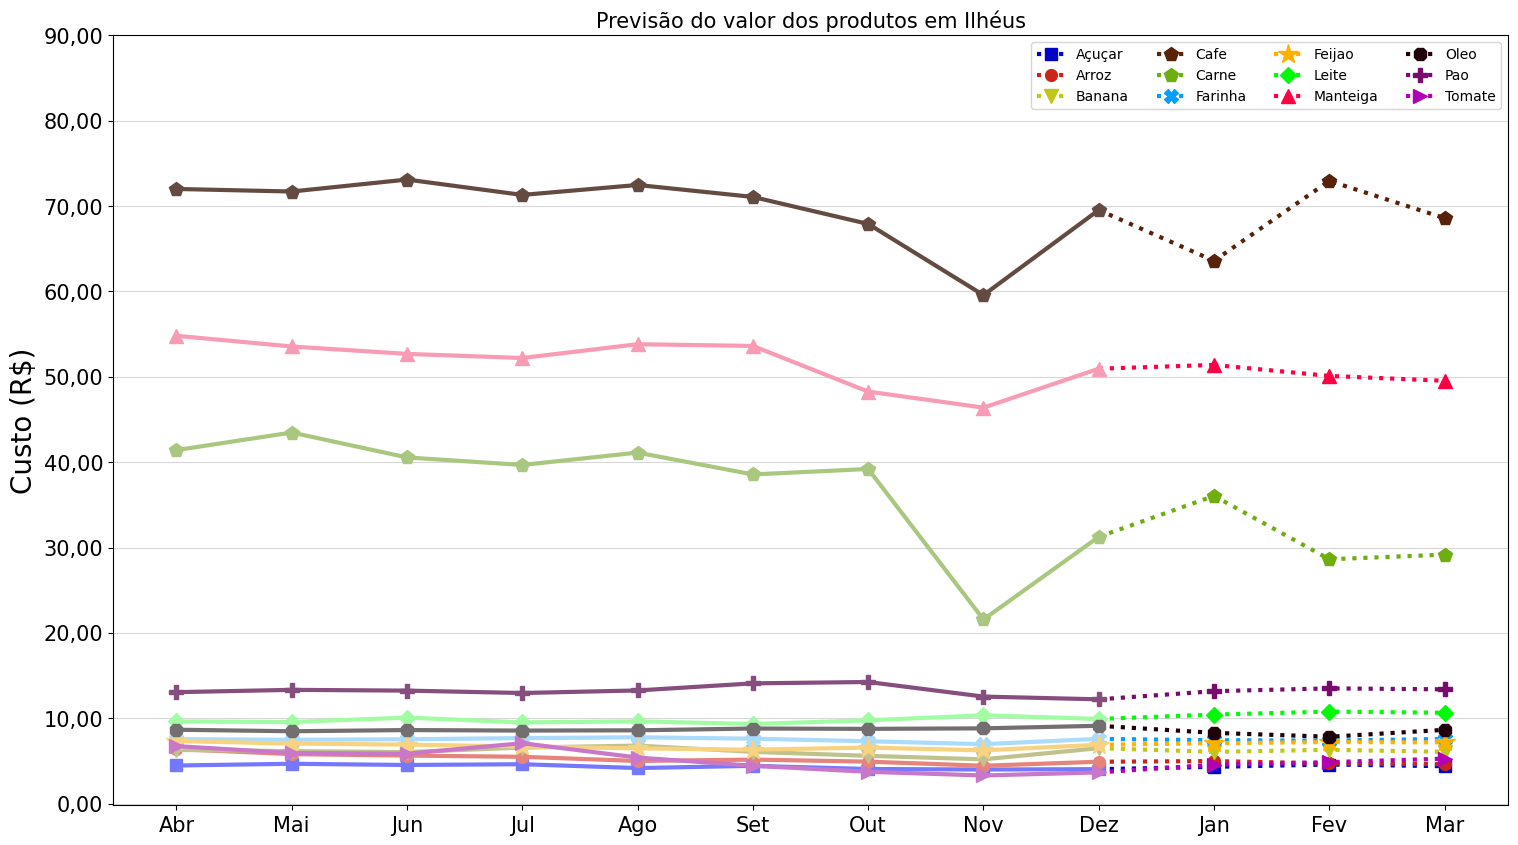

✅ Gráfico de Ilhéus salvo


In [23]:
# Obter limite do eixo Y e labels do eixo X
limite_y = int(configs['PRODUTOS']['eixo_y_limite_sup']) + 1
x_label = meses_anteriores + meses_previstos

# Criar figura
fig, ax = plt.subplots(figsize=(18, 10))

# Plotar usando função utilitária
plot_product_chart(
    ax, PRODUTOS, valores_reais_ios, produtos_previsoes['ilheus'],
    MARKERS_PRODUTOS, COLORS_REAL, COLORS_PREV, MARKERS_SIZE_PRODUTOS,
    LINE_SIZE, x_label, limite_y
)

# Título e legenda
ax.set_title("Previsão do valor dos produtos em Ilhéus", size=15)
ax.legend(ncol=4)

# Salvar
chart_name = f'../../output/figure/produtos_ilheus/previsao_produtos_{meses_previstos[0]}-{meses_previstos[-1]}_{ano_previsao}_ilheus.png'
plt.savefig(fname=chart_name, dpi=300, bbox_inches='tight')

plt.show()
print(f"✅ Gráfico de Ilhéus salvo")

## Previsão dos produtos de Itabuna

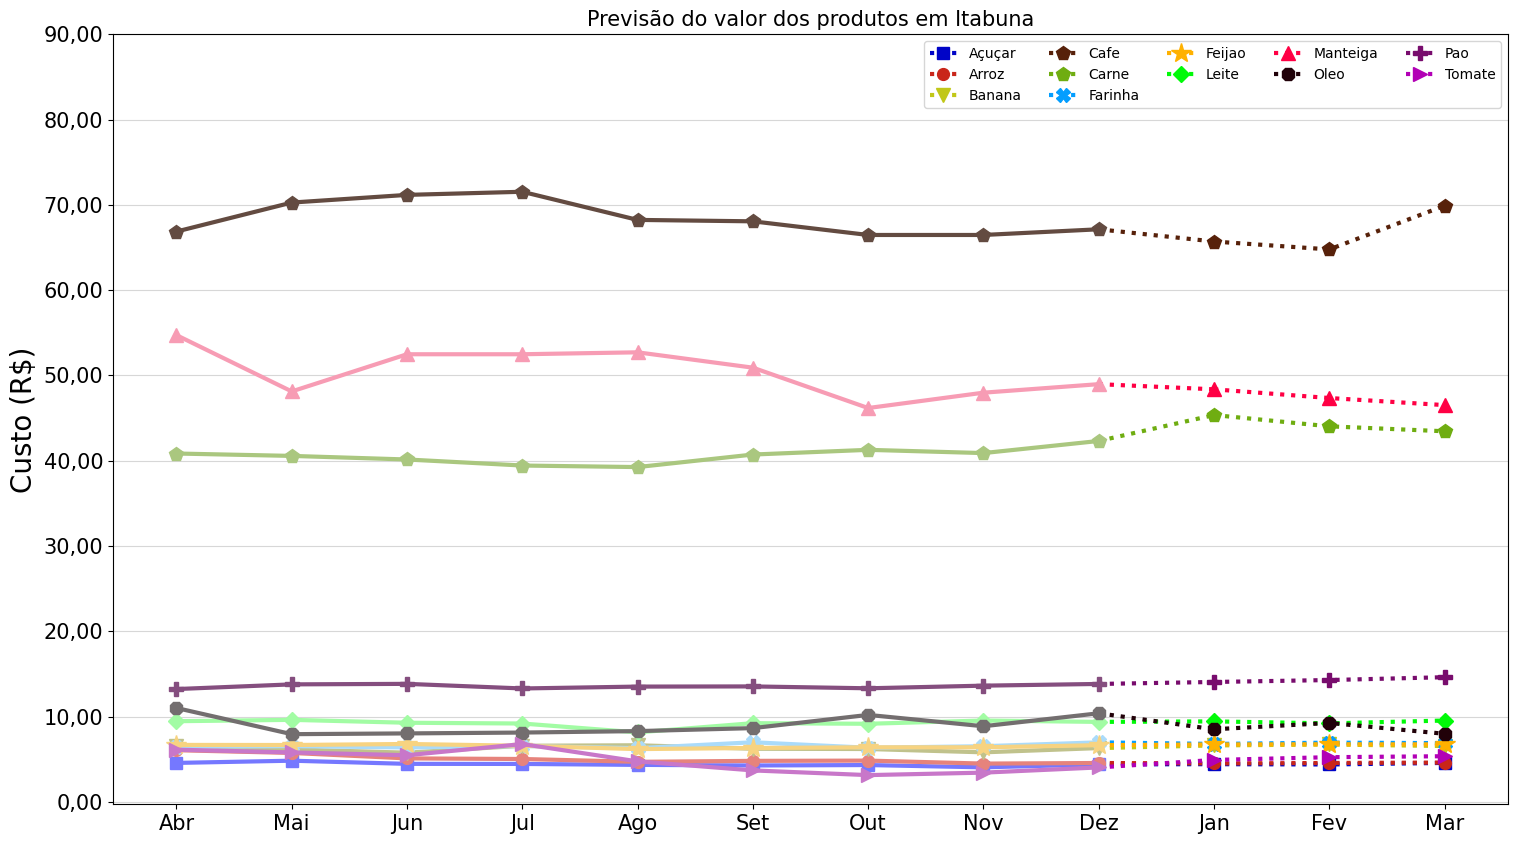

✅ Gráfico de Itabuna salvo


In [24]:
# Criar figura
fig, ax = plt.subplots(figsize=(18, 10))

# Plotar usando função utilitária
plot_product_chart(
    ax, PRODUTOS, valores_reais_itb, produtos_previsoes['itabuna'],
    MARKERS_PRODUTOS, COLORS_REAL, COLORS_PREV, MARKERS_SIZE_PRODUTOS,
    LINE_SIZE, x_label, limite_y
)

# Título e legenda
ax.set_title("Previsão do valor dos produtos em Itabuna", size=15)
ax.legend(ncol=5)

# Salvar
chart_name = f'../../output/figure/produtos_itabuna/previsao_produtos_{meses_previstos[0]}-{meses_previstos[-1]}_{ano_previsao}_itabuna.png'
plt.savefig(fname=chart_name, dpi=300, bbox_inches='tight')

plt.show()
print(f"✅ Gráfico de Itabuna salvo")